Exploring Google-related News in Hacker News
------

* By Tong Wang <tongwang@google.com>
* Built with: [Google BigQuery](https://cloud.google.com/bigquery/what-is-bigquery), [Google Cloud Datalab](http://datalab.cloud.google.com)
* Dataset shared at https://bigquery.cloud.google.com/dataset/bigquery-public-data:hacker_news
* Inspired by: 
    * Felipe Hoffa [Analyzing Hacker News data](https://github.com/fhoffa/notebooks/blob/master/analyzing%20hacker%20news.ipynb)
    * Corrie Elston [Riffing on Analyzing Hacker News](https://github.com/corrieelston/datalab/blob/master/HackerNews.ipynb)


Google recently launched the Public Datasets program, making a number of interesting datasets freely available and easily accessible on BigQuery. This includes the Hacker News dataset which contains all stories and comments from Hacker News from its launch in 2006 up to October 2015. Fellow Googlers Felipe and Corrie have made brilliant explorative analyses on the dataset using Cloud Datalab (see above).

As a Googler myself and an avid reader of HN, my question here is: what about stories and comments specifically related to Google, how are they trending on HN, what are the hot topics?

In this notebook we will (rather crudely) explore a few things:
* How many stories/comments are about Google, how are they trending?
* What are popular topics associated with Google, how are they trending?

Let's start with imports.

In [86]:
import gcp.bigquery as bq
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
from __future__ import print_function

## How many stories/comments are about Google? How are they trending?

We define:
* A story to be _Google-related_  if the story title contains the word 'Google' (case insensitive).
* A comment to be _Google-realted_  if the comment text contains the word 'Google' (case insensitive).

Write queries:

In [87]:
%%sql --module google

DEFINE QUERY stories
SELECT STRFTIME_UTC_USEC(time_ts, "%Y-%m") AS month,
  COUNT(*) AS story_count,
  SUM(IF(LOWER(title) CONTAINS 'google', 1, 0)) AS google_story_count,
  SUM(IF(LOWER(title) CONTAINS 'google', 1, 0)) / COUNT(*) AS google_story_share
FROM [bigquery-public-data:hacker_news.stories]
WHERE Date(time_ts) < '2015-10'
GROUP BY 1
ORDER BY 1 ASC

DEFINE QUERY comments
SELECT STRFTIME_UTC_USEC(time_ts, "%Y-%m") AS month,
  COUNT(*) AS comment_count,
  SUM(IF(LOWER(text) CONTAINS 'google', 1, 0)) AS google_comment_count,
  SUM(IF(LOWER(text) CONTAINS 'google', 1, 0)) / COUNT(*) AS google_comment_share
FROM [bigquery-public-data:hacker_news.comments]
WHERE Date(time_ts) < '2015-10'
GROUP BY 1
ORDER BY 1 ASC

Get the data from BigQuery:

In [88]:
google_stories = bq.Query(google.stories).to_dataframe().set_index('month')
google_comments = bq.Query(google.comments).to_dataframe().set_index('month')

Plot the share of stories and comments related to Google over time:

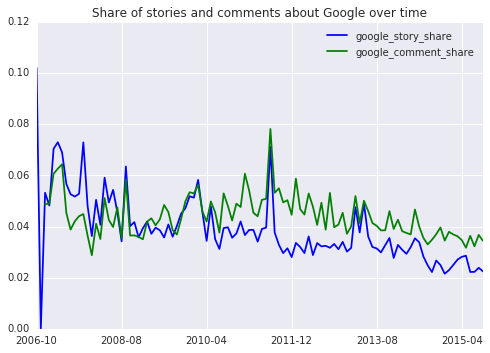

In [89]:
_ = pd.concat([google_stories['google_story_share'], 
               google_comments['google_comment_share']], 
              axis=1).plot(title = 'Share of stories and comments about Google over time')

The share of stories about Google hovers between 2% and 6%, the share of comments about Google hovers between 3% and 6%. The share of comments has been consistenly higher than the sahre of stories since 2010, so this implies that Google-related stories generate more comments per story compared to HN average.

Witness the spike of stories and comments in July 2011. What was that? We will find that out as we explore along in this notebook.

Also notice that both shares have been trending down in recent years. This is due to the decline of Google-related stories and comments while the overall number of stories and comments on HN have remained stable.

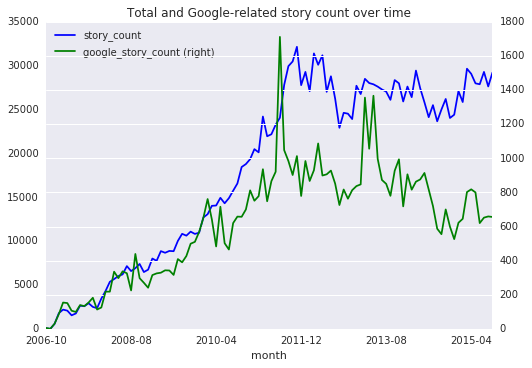

In [90]:
_ = google_stories['story_count'].plot(label='story_count', legend=True,
                                      title = 'Total and Google-related story count over time')
_ = google_stories['google_story_count'].plot(secondary_y=True, label='google_story_count',
                                             legend=True)

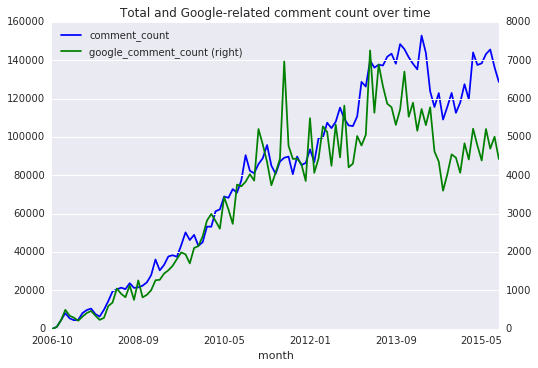

In [91]:
_ = google_comments['comment_count'].plot(label='comment_count', legend=True,
                                      title = 'Total and Google-related comment count over time')
_ = google_comments['google_comment_count'].plot(secondary_y=True, label='google_comment_count',
                                             legend=True)

## What are popular topics associated with Google? How are they trending?

Start with queries:

In [92]:
%%sql --module google_topic

SELECT STRFTIME_UTC_USEC(time_ts, "%Y-%m") AS month,
  COUNT(*) AS google_story_count,
  SUM(IF(LOWER(title) CONTAINS $topic, 1, 0)) AS topic_story_count,
  SUM(IF(LOWER(title) CONTAINS $topic, 1, 0)) / COUNT(*) AS topic_story_share
FROM [bigquery-public-data:hacker_news.stories]
WHERE Date(time_ts) < '2015-10'   #Leave out October 2015 data which is incomplete
AND LOWER(title) CONTAINS 'google'
GROUP BY 1
ORDER BY 1 ASC

Among Google-related stories, how about the shares of specific topics (e.g. Maps, Cloud, Larry, Facebook)?

In [93]:
cloud_stories = bq.Query(google_topic, topic='cloud').to_dataframe().set_index('month')
api_stories = bq.Query(google_topic, topic='api').to_dataframe().set_index('month')
facebook_stories = bq.Query(google_topic, topic='facebook').to_dataframe().set_index('month')
privacy_stories = bq.Query(google_topic, topic='privacy').to_dataframe().set_index('month')
larry_stories = bq.Query(google_topic, topic='larry').to_dataframe().set_index('month')

Plot the share of Google-related stories whose title also contains certain topic keywords:

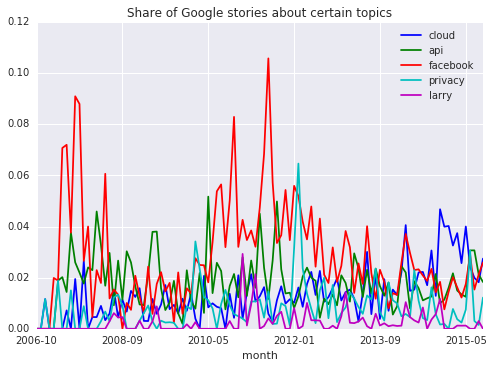

In [94]:
df = pd.concat([cloud_stories['topic_story_share'],
               api_stories['topic_story_share'],
              facebook_stories['topic_story_share'],
              privacy_stories['topic_story_share'],
              larry_stories['topic_story_share']],axis=1)
df.columns = ['cloud', 'api', 'facebook', 'privacy', 'larry']
_ = df.plot(title = 'Share of Google stories about certain topics')

The share of Google-related stories about Facebook also spiked in July 2011. Any guesses? :)

Notice 'Cloud' has a surge in popularity since 2014. 

Pity that we do not have data after 2015 October, otherwise we can probably see interesting trends on topics like ML, AI and Alphago in recent months.


The exploration above was more or less random: we selected a few abitrary topics that seemed interesting. Now let's do this a bit more systematically and first find out what are the most popular words that appear in Google-related story titles.

In [95]:
%%sql --module google_titles

SELECT lower(title) AS title
FROM [bigquery-public-data:hacker_news.stories]
WHERE LOWER(title) CONTAINS 'google'

In [96]:
#Pull all the story titles that contain 'google' from BigQuery
google_titles = bq.Query(google_titles).to_dataframe()

In [97]:
#Tokenize the titles into a list individual words
google_titles_words = []
for _, row in google_titles.iterrows():
  for word in row['title'].split():
    try:
      google_titles_words.append(str(word))
    except:
      pass
    
#Count the number of appearances of each word
words = {}
for word in google_titles_words:
  if word in words:
    words[word] += 1
  else:
    words[word] = 1

In [98]:
#Convert the dict into a pandas dataframe, sort by appearances, and print out the top 100 items
df = pd.DataFrame(words.items(), columns = ['word', 'apps'])
df = df.sort_values(['apps'], ascending=False)
pd.set_option('display.max_rows', 1000)
df[:100]

,word,apps
39894,google,53354
23040,to,14013
13917,the,10431
11311,for,8477
42177,and,6926
36798,a,6683
16645,in,6643
20270,of,6051
20265,on,5843
16635,is,5130


Many of the top words are function words and are not that interesting (e.g. 'to', 'the', 'for'). If we leave them out we get to a list of (content) words that are most frequently associated with Google in HN story titles (e.g. 'search', 'chrome', 'android'), which do seem interesting.

For example, let's compile a list of Google products and investigate how their popularity on HN has developed over time.

In [99]:
topics = ['search', 'google+', 'android', 
          'maps', 'analytics', 'cloud', 
         'api', 'reader', 'glass']

Pull data from BigQuery. Compute the share of stories on each topic among all Google-related stories and its yoy change.

In [100]:
topic_trends = pd.DataFrame()
topic_trends_yoy = pd.DataFrame()
for topic in topics:
  stories_count = bq.Query(google_topic, topic=topic).to_dataframe().set_index('month')
  topic_trends[topic] = stories_count['topic_story_share']
  topic_trends_yoy[topic] = stories_count['topic_story_share'] - stories_count['topic_story_share'].shift(12)

Plot the share of Google-related stories on each topic over time:

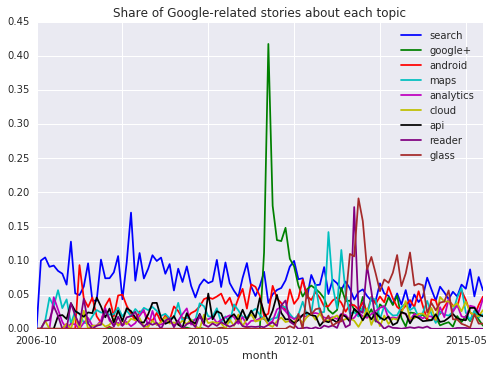

In [101]:
mpl.rcParams['axes.color_cycle'] = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'brown', 'lime']
_ = topic_trends.plot(title='Share of Google-related stories about each topic')

We can see the surge of popularity of Google+ (July 2011) and Glass (April 2014) around launch.

In [102]:
%%sql --module july2011

SELECT lower(title) AS title, score 
FROM [bigquery-public-data:hacker_news.stories]
WHERE LOWER(title) CONTAINS 'google'
AND STRFTIME_UTC_USEC(time_ts, "%Y-%m") = '2011-07'
ORDER BY 2 DESC
LIMIT 50;

Top Google stories in July 2011. Many of them are indeed about Google+. This probably also explains the high association with Facebook that we saw previously.

In [103]:
july2011_stories = bq.Query(july2011).to_dataframe()
july2011_stories

,title,score
0,google made my son cry,583
1,steve yegge quits google in the middle of his ...,546
2,xkcd's randall munroe on google+ requiring you...,463
3,remove any site from google (even if you don't...,447
4,code.google.com now supports git,445
5,"ex-wave, ex-plus engineer on google plus",441
6,why i left google. what happened to my book. w...,321
7,google deletes last 7 years of user's digital ...,308
8,"putting ""search"" into google yields a surprisi...",301
9,google labs winding down,283


The previous line charts were not the easiest on the eye. Now let's zoom in to the last full month of data that we have (September 2015), and plot the popularity of each topic and the yoy change as bar charts.

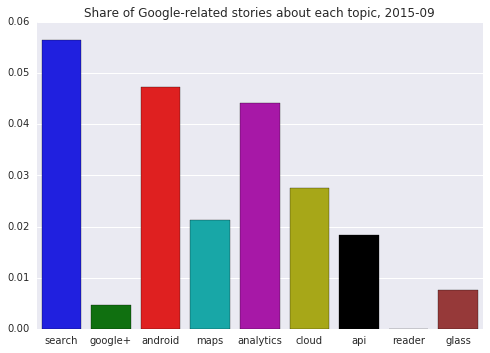

In [104]:
mpl.rcParams['axes.color_cycle'] = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'brown', 'lime']
_ = sns.barplot(data=topic_trends['2015-09':])
_ = sns.plt.title('Share of Google-related stories about each topic, 2015-09')

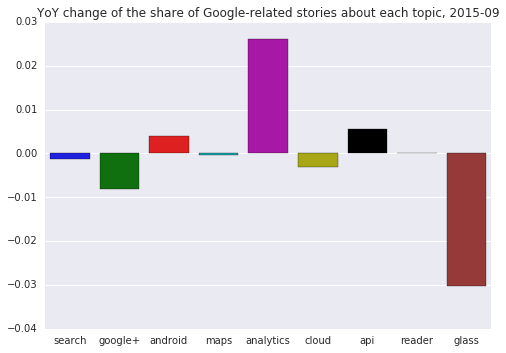

In [105]:
_ = sns.barplot(data=topic_trends_yoy['2015-09':])
_ = sns.plt.title('YoY change of the share of Google-related stories about each topic, 2015-09')

Search and Android still take the lion's share of Google topicality on HN, while Analytics and Cloud are serious contenders. Analytics is quickly rising in popularity compared to one year ago, followed by our API offerings. 